# Implementing the Perceptron Algorithm

### Abstract

In this post, we are going to implement the perceptron algorithm under different conditions of raw data. The perceptron algorithm is a binary linear classifier that learns to construct a decision boundary that classifies two classes of data points in a feature space. The algorithm works when the two classes of data are linearly separable: the perceptron converges to a line that completely separates the two classes as the error of missclassification converges to zero. In the post we will show that property applies to not only two 2 dimensional linear separable data but also multidimensional linear separable data. However, for data points that are not linearly separable, the perceptron will find it hard to adjust and converge to a line which has zero error in classifying the data. To make sure that the error converges for data that are not linearly separable, we introduce Minibatch Perceptron algorithm so that the algorithm could arrive at a line that separates the two classes with the least error. The more detailed version of the classical and Minibatch perceptron algorithm is presented in these two files ['perceptron.py'](perceptron.py) and ['MBperceptron.py'](MBperceptron.py). 

In [3]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
from MBperceptron import MBPerceptron, MBPerceptronOptimizer

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Part A: Implement Perceptron

First, we want to create some data points of two categories that are linearly separable for the algorithm to run on. Here is the code to generate random data points of two categories that are linearly separable. 

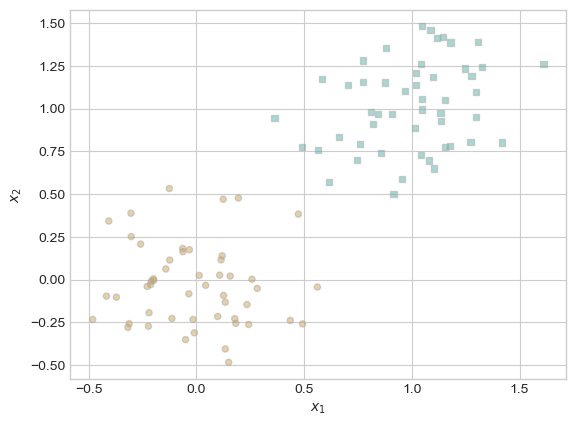

In [4]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(12989)

def perceptron_data(n_points = 100, noise = 0.23, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 100, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

These are $n = 100$ points of data. Each data point $i$ has two features $x_{i1}$, $x_{i2}$, and a target variable $y_i$. Each data points stack onto each other to form these two matrices $\mathbf{X}$ and $\mathbf{y}$.
$$
\mathbf{X} = \left[\begin{matrix} & - & \mathbf{x}_1 & - \\ 
& - & \mathbf{x}_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \mathbf{x}_{n} & - \end{matrix}\right]
$$
$$
\mathbf{y} = (y_1, \ldots, y_{n})^T \in \{-1,1\}^{n}
$$
In this data set, the target variable has components equal to either $-1$ or $1$. 

Now, we want to implement the classical perceptron algorithm. Recall from the lecture note provided by Professor Chodrow that describes the steps of the perceptron algorithm:

> The perceptron algorithm aims to find a good choice of $\mathbf{w}$ that makes the loss small using the following algorithm: 
> 1. Start with a *random* $\mathbf{w}^{(0)}$. 
> 2. "Until we're done," in each time-step $t$, 
>    - Pick a random data point $i \in \{1,\ldots,n\}$. 
>    - Compute $s^{(t)}_i = \langle \mathbf{w}^{(t)}, \mathbf{x}_i \rangle$. 
>    - If $s^{(t)}_i y_i > 0$, then point $i$ is currently correctly classified -- do nothing! 
>    - Else, if $s^{(t)}_i y_i < 0$, then perform the update $$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + y_i \mathbf{x}_i\;.$$ {#eq-perceptron-update}

The steps above are functions `Perceptron.grad()` and `PerceptronOptimizer.step()` in the file ['perceptron.py'](perceptron.py). Here, I will walk you through the `Perceptron.grad()` algorithm through comments by the code. 

In [5]:
def grad(self, X, y):
    s_i = X@self.w  # matrix calculation of the weight and the data point x to get the score using the torch @ operator
    y_ = 2 * y - 1  # convert the target feature value from 0 and 1 to -1 and 1. 
    v = s_i*y_      # if all the points are classified correctly
    return (v < 0).float() * X * y_   # if all of them are correct, then no need to update the weight vector. If not, then we return a grad that will be used to update the weight vector and the decsion boundary

To verify that our classical perceptron algorithm is working, we want to implement a minimal training loop using the data we have already generated in the beginning of the post. 

In [6]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)
p.loss(X, y)

# define loss variable
loss = 1.0

# for keeping track of loss values
loss_vec = []
iter = 0

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    iter += 1

print(iter)

115


The loop terminates repeating 115 times and therefore the loss converges to 0. My algorithm works! Now let's move to the experiment part where we use the perceptron algorithm to different types of data points. 

### Part B: Experiments

#### Part B.1: Linearly Separable 2D data

We will use the original data points we used for the minimal training loop above to illustrate the evolution of the loss function and the final separation line that the algorithm converges to. 

Text(0.5, 1.0, 'Evolution of Loss Function')

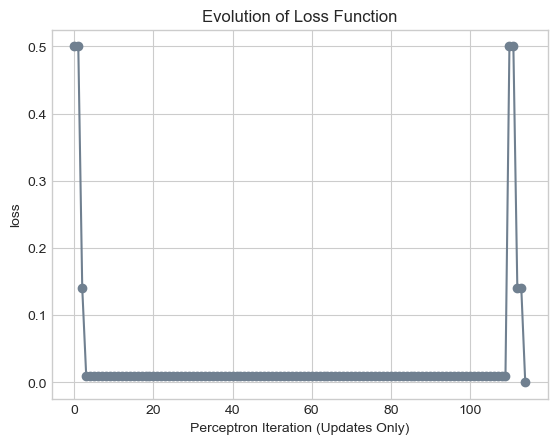

In [7]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title("Evolution of Loss Function")

Above is the graph that shows the evolution of the loss function. It is interesting to see that the loss function was very close to 0 between step 7 to step 110 but later iater increases. It demonstrates the randomness of the perceptron algorithm when selecting data points for adjustment. It may take the algorithm a while to find the data point that the algorithm fails to classify correctly. 

Next, we want to see how does the line that separates the two classes apart looks like. 

Text(0.5, 1.0, 'Final Decision Boundary')

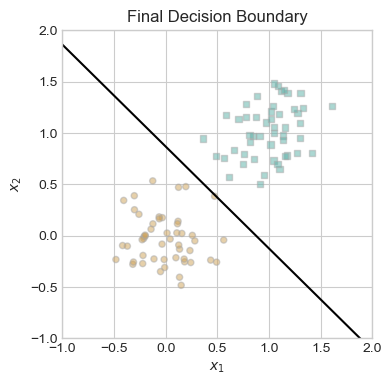

In [9]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")
plt.title("Final Decision Boundary")

A line that has perfectly separated the two classes. How have this line changed throughout the training process? The following figure illustrates the perceptron algorithm in action over several iterations. The code is adopted from the lecture note provided by Professor Chodrow. 

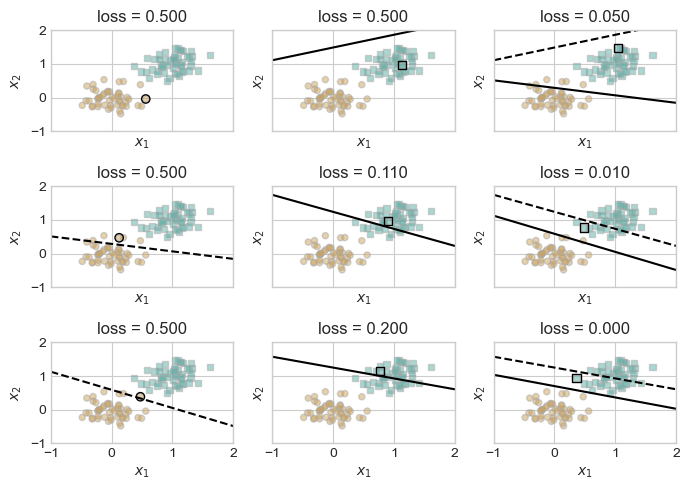

In [177]:
torch.manual_seed(127)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(3, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(x_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y_i.item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1

plt.tight_layout()

#### Part B.2: Non-linearly Separable 2D data

It is often rare in reality to have two classes of data that are linearly separable. What will happen if the perceptron data handles a non-linearly separable 2D data? First, we want to create data points that are nonlinearly seperable. To do that, I increase the noise parameter in the function. 

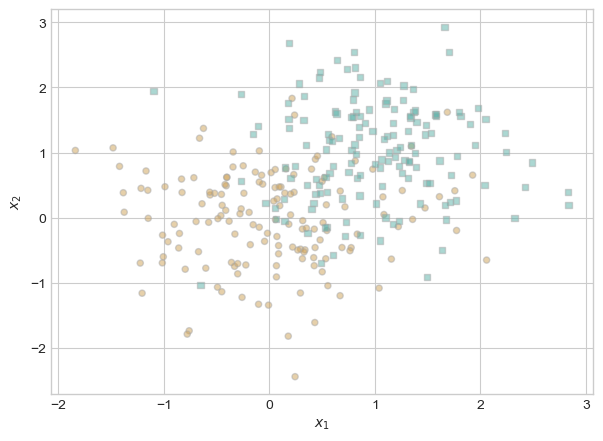

In [178]:
def nonseperable_perceptron_data(n_points=300, noise=0.7, p_dims=2):
    y = torch.arange(n_points) >= int(n_points / 2)
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2 * y - 1

    return X, y

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X_1, y_1 = nonseperable_perceptron_data()
plot_perceptron_data(X_1, y_1, ax)

The two classes of data are mixed. Now we want to implement the perceptron algorithm. We know that the loss function will not converge to 0, so we limit the iteration of the loop to 1000 times. 

In [179]:
# instantiate a model and an optimizer
p_1 = Perceptron() 
opt = PerceptronOptimizer(p_1)
p_1.loss(X_1, y_1)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X_1.size()[0]
iteration = 0

while loss > 0 and iteration < 1000: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p_1.loss(X_1, y_1) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X_1[[i],:]
    y_i = y_1[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    iteration += 1

Text(0.5, 1.0, 'Evolution of Loss Function')

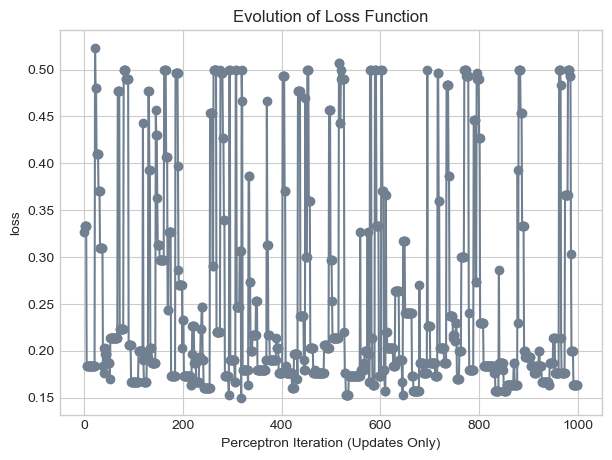

In [180]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title("Evolution of Loss Function")

The loss oscillates throughout the iteration and does not have a pattern of convergence. How does the final separation line looks? 

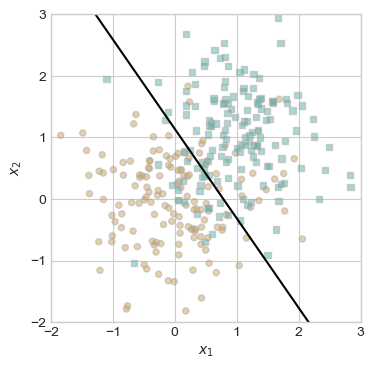

In [181]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-2, 3), ylim = (-2, 3))
plot_perceptron_data(X_1, y_1, ax)
draw_line(p_1.w, -2, 3, ax, color = "black")
plt.title("Final Decision Boundary")

#### Part B.2: Linearly Separable 5D data

It is easier for us to understand how the algorithm work and visualize its process in a 2 dimensional space. The perceptron algorithm could work in higher dimensions as well! Now, we want to create data points with 5 features and use the graph of the loss function to determine whether the data is linearly separable or not. 

In [187]:
torch.manual_seed(989)

def d5_perceptron_data(n_points=150, noise=0.2, p_dims=5):
    y = torch.arange(n_points) >= int(n_points / 2)
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2 * y - 1

    return X, y

X_5, y_5 = d5_perceptron_data()


Text(0.5, 1.0, 'Evolution of Loss Function')

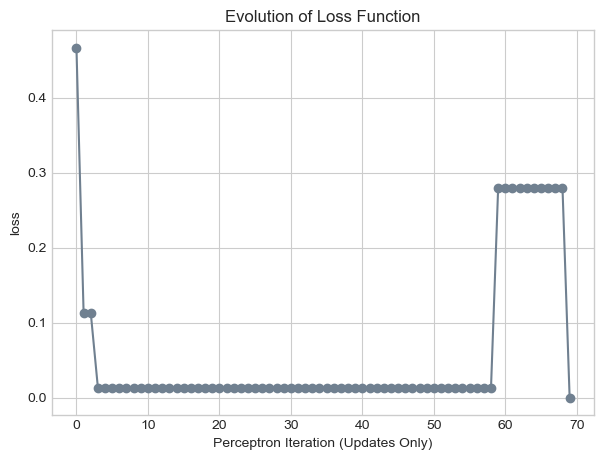

In [188]:
# instantiate a model and an optimizer
p_5 = Perceptron() 
opt = PerceptronOptimizer(p_5)
p_5.loss(X_5, y_5)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X_5.size()[0]
iteration = 0

while loss > 0 and iteration < 1000: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p_5.loss(X_5, y_5) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X_5[[i],:]
    y_i = y_5[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    iteration += 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title("Evolution of Loss Function")

The loss function converges after 61 iterations! Since the algorithm terminates and the loss converges to zero, we know that the two classes are linearly separable in this 5 dimensional space. 

### Part C: Minibatch Perceptron Experiments

Now, I am introducing a new perceptron algorithm called Minibatch Perceptron. Different from the classic perceptron algorithm that updates the weight vector and the linear separation line with only one random data point, the Minibatch perceptron algorithm updates them with $k$ random data points. Mathematically, in each step

- Pick $k$ random indices from $i \in \{1,\ldots,n\}$. 
- Perform the update $$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + \frac{\alpha}{k} \sum_{j=1}^k \mathbb{1} [\langle \mathbf{w}^{(t)}, \mathbf{x}_{i_j} \rangle y_{i_j} < 0] y_{i_j} \mathbf{x}_{i_j} $$

The equation above computes $k$ perceptron increments, average them, and apply it to the weight vector. The hyperparameter $\alpha$ is a learning rate that determines how quickly the weight vector changes in each iteration. The learning rate can be changed to get ideal result.

The code for the algorithm is embedded in the file [`MBperceptron.py`](MBperceptron.py). I want to thank Professor Chodrow and Lima Smith for providing me inspiration and help on improving this algorithm. Here, I am creating a function for implementing Minibatch Experiment. 

In [184]:
def MB_experiment(X, y, k, alpha):
    torch.manual_seed(8972)

    # instantiate a model and an optimizer
    mb_p = MBPerceptron() 
    mb_opt = MBPerceptronOptimizer(mb_p)
    mb_p.loss(X, y)

    loss_mb = 1.0

    # for keeping track of loss values
    loss_vec_mb = []
    iter = 0

    while loss_mb > 0: 
    
        # tracking our progress    
        loss_mb = mb_p.loss(X, y) 
        loss_vec_mb.append(loss_mb)

        # pick several random data points
        ix = torch.randperm(X.size(0))[:k]
        X_i = X[ix,:]
        y_i = y[ix]
    
        # perform a perceptron update using the random data point
        mb_opt.step(X_i, y_i, k, alpha)

        # set iteration limit
        iter += 1
        if iter >= 1000:
            break

    return loss_vec_mb, mb_p.w

#### Part C.1: $k = 1$

In a Minibatch Perceptron, when $k= 1$, it should perform just like the classic perceptron algorithm as it is updated using 1 random points in each iteration

In [185]:
loss_vec_mb_k1, w_k1 = MB_experiment(X, y, k = 1, alpha = 1)

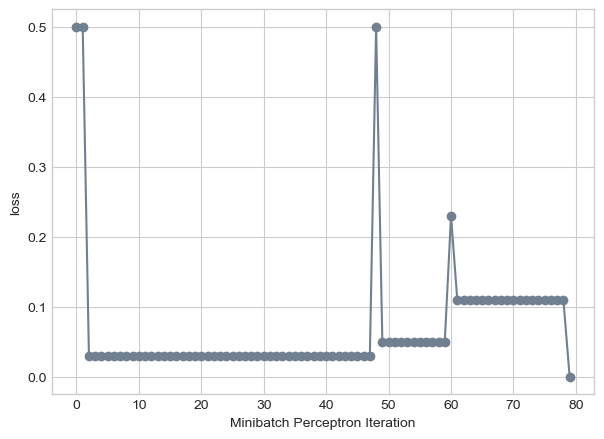

In [186]:
plt.plot(loss_vec_mb_k1, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_mb_k1)), loss_vec_mb_k1, color = "slategrey")
labs = plt.gca().set(xlabel = "Minibatch Perceptron Iteration", ylabel = "loss")
plt.title("Evolution of Loss Function")

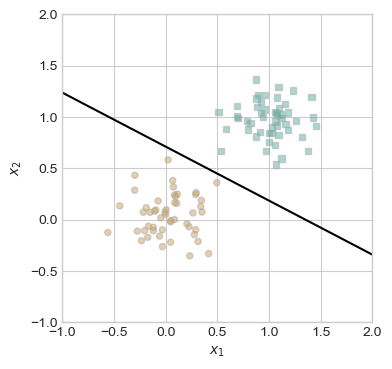

In [125]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(w_k1, -1, 2, ax, color = "black")
plt.title("Final Decision Boundary")

#### Part C.2: $k = 10$

Now, when $k = 10$, the algorithm selects randomly 10 points and average their loss to update the linear separation line.

In [126]:
loss_vec_mb_k10, w_k10 = MB_experiment(X, y, k = 10, alpha = 1)

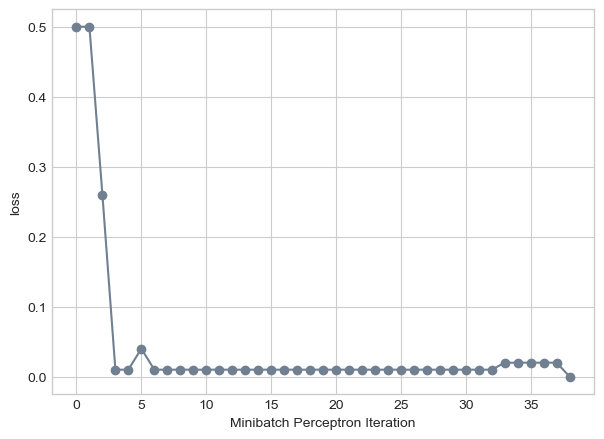

In [127]:
plt.plot(loss_vec_mb_k10, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_mb_k10)), loss_vec_mb_k10, color = "slategrey")
labs = plt.gca().set(xlabel = "Minibatch Perceptron Iteration", ylabel = "loss")
plt.title("Evolution of Loss Function")

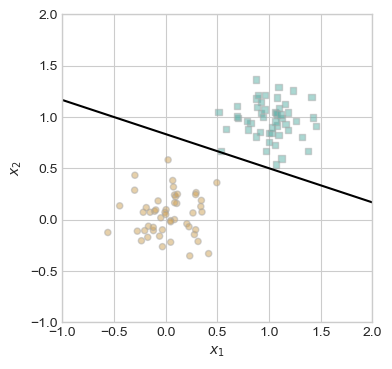

In [128]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(w_k10, -1, 2, ax, color = "black")
plt.title("Final Decision Boundary")

When $k = 10$, the loss function converges faster and has less oscillation. The algorithm is still able to find a linear separation line between the two classes. 

#### Part C.3: Non-linearly Separable Data and Minibatch Perceptron

Compared with the classic perceptron algorithm, minibatch perceptron can converge even when the data is not linearly separable. Though it is impossible for the loss to converge to 0 (perfectly classifying the data) since the data points are not linearly separable, it can help us to find a line that can classify the data points with the highest accuracy. In this part, we set $k = n$, where $n$ is the number of total data points, and tune the learning rate $\alpha$. First, let $\alpha = 1$

In [129]:
loss_vec_mb_kn, w_kn = MB_experiment(X_1, y_1, k = X.size()[0], alpha = 1)

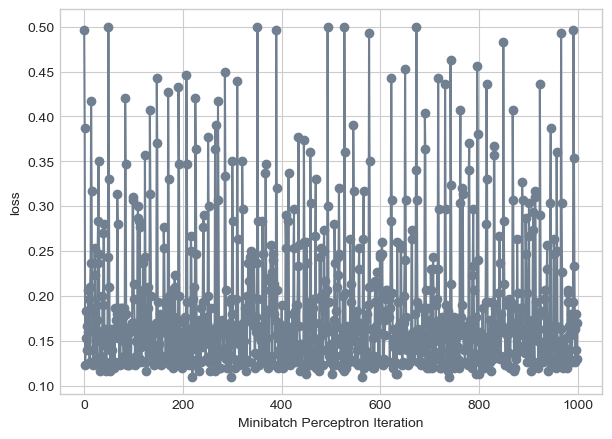

In [130]:
plt.plot(loss_vec_mb_kn, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_mb_kn)), loss_vec_mb_kn, color = "slategrey")
labs = plt.gca().set(xlabel = "Minibatch Perceptron Iteration", ylabel = "loss")
plt.title("Evolution of Loss Function")

We see that the loss function is still oscillating (just like how it was before) and does not seem to converge within 1000 iterations. Now, we rigorously decrease $\alpha$ and let $\alpha = 0.001$. 

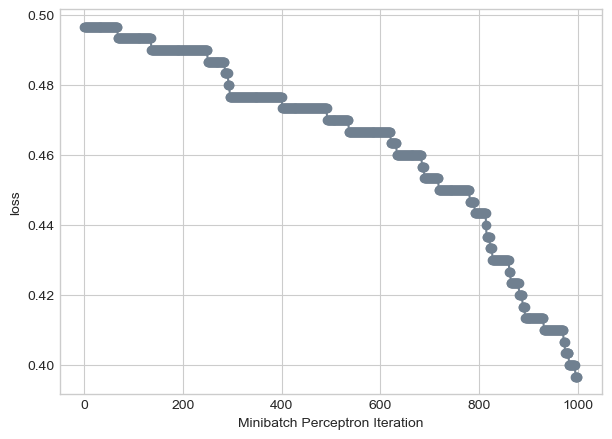

In [131]:
loss_vec_mb_kn_0_001, w_kn_0_001 = MB_experiment(X_1, y_1, k = X.size()[0], alpha = 0.001)
plt.plot(loss_vec_mb_kn_0_001, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_mb_kn_0_001)), loss_vec_mb_kn_0_001, color = "slategrey")
labs = plt.gca().set(xlabel = "Minibatch Perceptron Iteration", ylabel = "loss")
plt.title("Evolution of Loss Function")

In this graph, the loss function seems to decrease gradually as we iterate the algorithm. After 1000 iterations, the loss decreases to 0.4, which is the best result among all iterations. Let's see how the decision boundary looks like. 

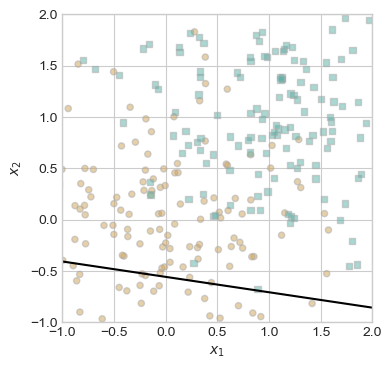

In [104]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X_1, y_1, ax)
draw_line(w_kn_0_001, -1, 2, ax, color = "black")
plt.title("Final Decision Boundary")

### Part D: Conclusion


In this blog post, we practiced writing down the gradient and step functions for the perceptron algorithm and implementing them in various data point scenarios. We experimented with the algorithm using 2D data that is linearly separable, non-linearly separable, and data points with more than 5 features. We found that when the data points are linearly separable, regardless of the number of dimensions, the loss function will converge to 0, and we will obtain a decision boundary that perfectly classifies the two classes. However, when the data is not linearly separable, the algorithm fails to converge to a decision boundary. To improve the algorithm's performance on non-linearly separable data points, we introduced the Minibatch Perceptron, allowing us to choose the learning rate of the algorithm, $\alpha$, and the number of random points used when evaluating and updating the decision boundary of the two classes, $k$. When $k=1$, the algorithm behaves similarly to the classic one. For non-linearly separable data, we found that when $k = n$ and a sufficiently small learning rate $\alpha$ is chosen, the algorithm can converge to a decision boundary that effectively separates the two classes. The blog post improved my understanding of the algorithm and helped me to learn the strength and weakness of the perceptron algorithm. 